In [146]:
import tensorflow
from tensorflow import keras

import logging
logging.getLogger('tensorflow').setLevel(logging.CRITICAL)

import os
import random
import numpy as np
import pandas as pd
import datetime
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from pprint import pprint

In [147]:
def set_seeds(seed=2022):
    random.seed(seed)
    np.random.seed(seed)
    tensorflow.random.set_seed(seed)

In [148]:
results_path = Path('results', 'lstm_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [149]:
data = pd.read_csv('spy.csv', index_col=0, parse_dates=True)[['Adj Close']]['2000':'2024']

/var/folders/7q/6sr3f8p154zcxjkx38dw3tfc0000gn/T/ipykernel_39771/3012542851.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv('spy.csv', index_col=0, parse_dates=True)[['Adj Close']]['2000':'2024']


In [150]:
data.shape

(6050, 1)

In [151]:
data.isna().sum()

Adj Close    0
dtype: int64

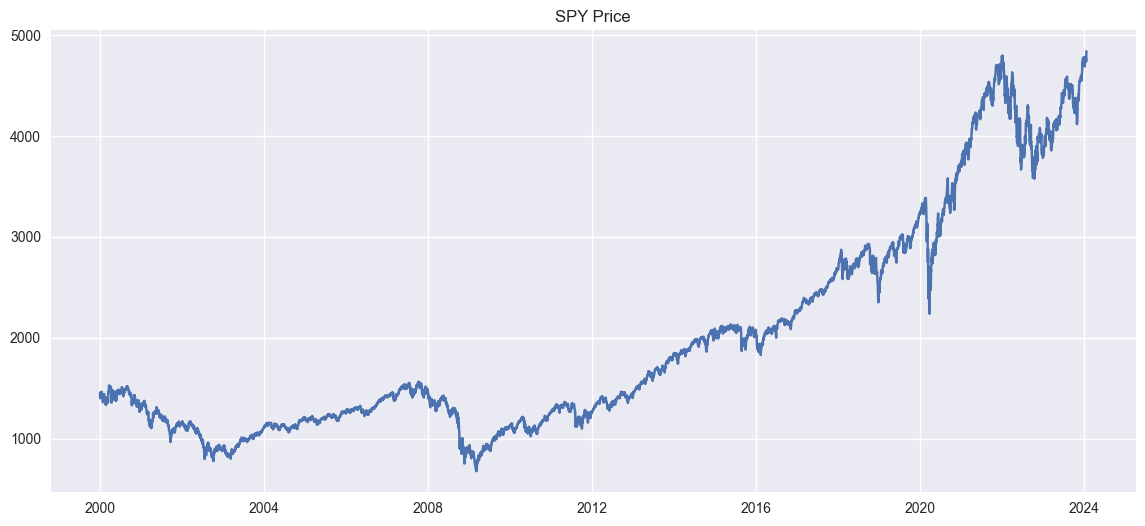

In [152]:
plt.figure(figsize=(14,6))
plt.title('SPY Price')
plt.plot(data);

In [153]:
train_data, test_data = train_test_split(data, 
                                         train_size=0.8,
                                         test_size=0.2,
                                         shuffle=False)
print(f"Train and Test Size {len(train_data)}, {len(test_data)}")

Train and Test Size 4840, 1210


In [154]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [155]:
# sequence length
lookback = 60

In [156]:
def generate_sequence(data, sequence_length=lookback):

    X = []
    y = []

    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i, 0])
        y.append(data[i, 0])

    return np.array(X), np.array(y)

In [157]:
X_train, y_train = generate_sequence(data=scaled_train_data,
                                     sequence_length=lookback)
print(f'X_train: {X_train.shape}, y_train {y_train.shape}')

X_train: (4780, 60), y_train (4780,)


In [158]:
X_test, y_test = generate_sequence(data=scaled_test_data,
                                   sequence_length=lookback)
print(f'X_test: {X_test.shape}, y_test {y_test.shape}')

X_test: (1150, 60), y_test (1150,)


In [159]:
# Reshape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = y_train[:, np.newaxis]

print(f'X_train Shape: {X_train.shape}, y_train {y_train.shape}')

X_train Shape: (4780, 60, 1), y_train (4780, 1)


In [160]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = y_test[:, np.newaxis] 

print(f'X_test Shape: {X_test.shape}, y_test {y_test.shape}')

X_test Shape: (1150, 60, 1), y_test (1150, 1)


In [161]:
def create_model(hu=256, lookback=60):

    tensorflow.keras.backend.clear_session()

    inputs = Input(shape=(lookback, 1))
    lstm = LSTM(units=hu, activation = 'relu', return_sequences=False, name='LSTM')(inputs)
    output = Dense(units=1, name='Output')(lstm)
    model = Model(inputs=inputs, outputs=output)

    opt = Adam(learning_rate=0.001,epsilon=1e-08)

    model.compile(optimizer=opt, loss='mse', metrics=['mae'])

    return model

In [162]:
model = create_model(hu=10, lookback=lookback)

In [163]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

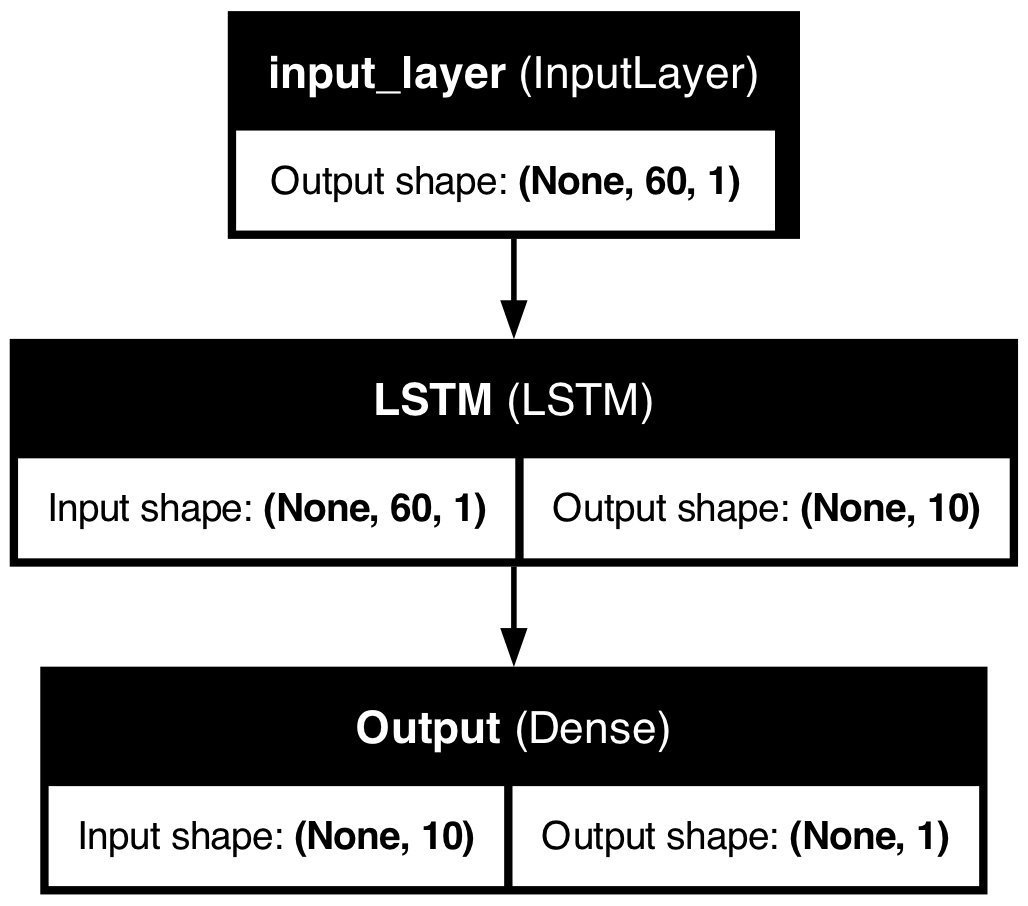

In [164]:
plot_model(model, to_file='lstm-1.png', show_shapes=True, show_layer_names=True)

In [165]:
# Specify callback functions
model_path = (results_path / 'model.keras').as_posix()
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

my_callbacks = [
    EarlyStopping(patience=10, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath=str(model_path), verbose=1, monitor='loss', save_best_only=True),
    TensorBoard(log_dir=logdir, histogram_freq=1)
]         

In [166]:
history = model.fit(X_train,
                    y_train,
                    batch_size=64,
                    epochs=500,
                    verbose=1,
                    callbacks=my_callbacks,
                    shuffle=False)

Epoch 1/500
63/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - mae: 0.0996
Epoch 1: loss improved from inf to 0.00541, saving model to results/lstm_time_series/model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0136 - mae: 0.0924
Epoch 2/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - mae: 0.0393
Epoch 2: loss improved from 0.00541 to 0.00154, saving model to results/lstm_time_series/model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - mae: 0.0392
Epoch 3/500
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - mae: 0.0258 
Epoch 3: loss improved from 0.00154 to 0.00084, saving model to results/lstm_time_series/model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9718e-04 - mae: 0.0258
Epoch 4/500
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7002e-04 - mae: 0.0195
Epoch 4: loss improved from 0.00084 to 0.00055, saving model to results/lstm_time_series/model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6981e-04 - mae: 0.

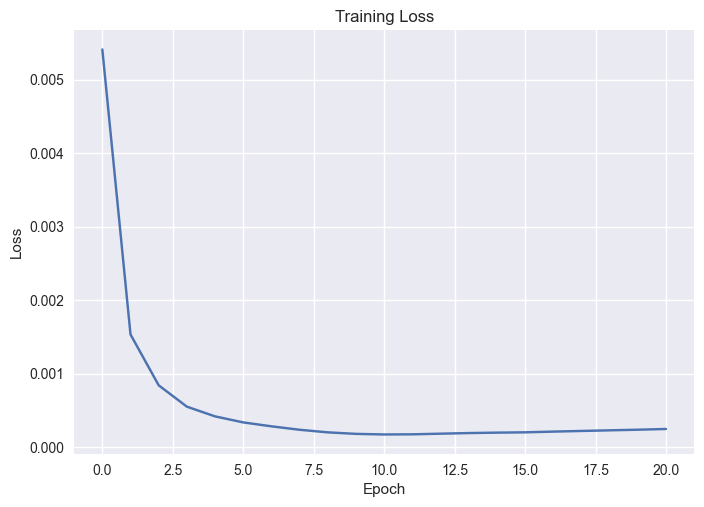

In [167]:
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [168]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [169]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 39694), started 18:48:01 ago. (Use '!kill 39694' to kill it.)

In [170]:
basemodel = create_model()

In [171]:
loss, acc = np.sqrt(basemodel.evaluate(X_test, y_test, verbose=0))
print("Untrained model, loss: {:5.2f}".format(loss))

Untrained model, loss:  1.34


In [172]:
# Loads the weights
new_model = tensorflow.keras.models.load_model('results/lstm_time_series/model.keras', compile=False)

new_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Show the model architecture
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [173]:
loss, acc = np.sqrt(new_model.evaluate(X_test, y_test, verbose=0))
print("Restored model, loss: {:5.2f}".format(loss))

Restored model, loss:  0.23


In [174]:
train_rmse_scaled = np.sqrt(basemodel.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(basemodel.evaluate(X_train, y_train, verbose=0))
print(f'Train RMSE: {train_rmse_scaled[0]:.4f} | Test RMSE: {test_rmse_scaled[0]:.4f}')

Train RMSE: 0.4147 | Test RMSE: 0.4147


In [175]:
train_rmse_scaled = np.sqrt(new_model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(new_model.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled[0]:.4f} | Test RMSE: {test_rmse_scaled[0]:.4f}')

Train RMSE: 0.0209 | Test RMSE: 0.2315


In [176]:
# predictions
y_pred = new_model.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [177]:
df = pd.DataFrame({
    'actual': scaler.inverse_transform(y_test).flatten(),
    'prediction': scaler.inverse_transform(y_pred).flatten()},
                  index = test_data[lookback:].index)

df['spread'] = df['prediction'] - df['actual']
df

,actual,prediction,spread
Date,,,
2019-06-26,2913.780029,2888.944580,-24.835449
2019-06-27,2924.919922,2890.078369,-34.841553
2019-06-28,2941.760010,2893.139648,-48.620362
2019-07-01,2964.330078,2898.613525,-65.716553
2019-07-02,2973.010010,2907.071289,-65.938721
...,...,...,...
2024-01-12,4783.830078,5706.845703,923.015625
2024-01-16,4765.979980,5719.978027,953.998047
2024-01-17,4739.209961,5729.728027,990.518066


In [178]:
print(f'R-square: {r2_score(df.actual, df.prediction):0.4}')

R-square: 0.2011


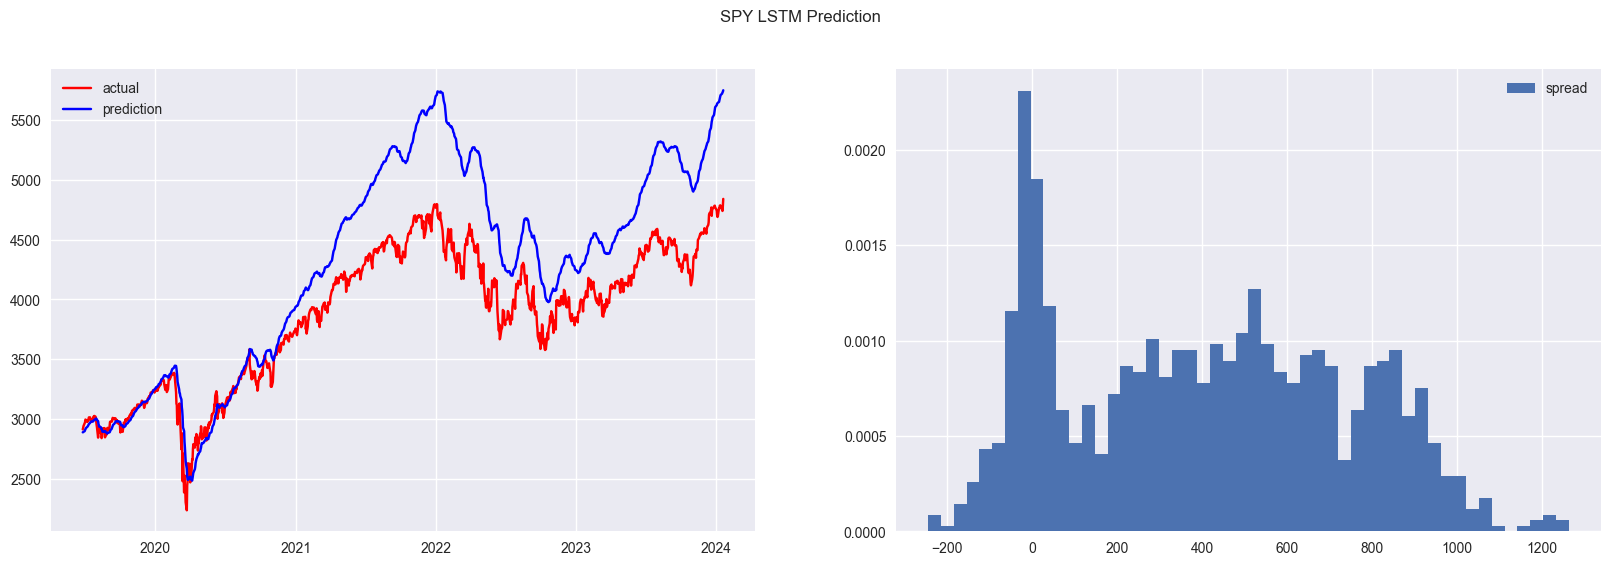

In [179]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

ax[0].plot(df.actual, color='red', label='actual')
ax[0].plot(df.prediction, color='blue', label='prediction')
ax[1].hist(df.spread, bins=50, density=True, label='spread')

ax[0].legend()
ax[1].legend()

plt.suptitle('SPY LSTM Prediction');